In [1]:
__author__ = "Leandro Candau Sánchez de Ybargüen"

# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.applications import DenseNet121
from keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split

In [2]:
# Use Kaggle API to download this PanNuke dataset sample from Kaggle: https://www.kaggle.com/datasets/andrewmvd/cancer-inst-segmentation-and-classification
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/cancer-inst-segmentation-and-classification")

print("Path to dataset files:", path)

/Users/candau/tfm/densenet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/candau/.cache/kagglehub/datasets/andrewmvd/cancer-inst-segmentation-and-classification/versions/4


## Loading the dataset

In [3]:
# Lets load the input dataset chosen, a subset of the PanNuke cancer segmentation dataset. https://link.springer.com/chapter/10.1007/978-3-030-23937-4_2
# This dataset has 2656 sample 256x256 RGB image patches, compossed of a pieces of Whole Slide Images (WSI).
# Along the images we have instance segmentation masks, an array of 6 channel instance-wise masks (0: Neoplastic cells, 1: Inflammatory, 2: Connective/Soft tissue cells, 3: Dead Cells, 4: Epithelial, 6: Background)
# Finally we have the types, repressenting the tissue type that a given path was extracted from.
images = np.load(f'{path}/Part 1/Images/images.npy')
masks = np.load(f'{path}/Part 1/Masks/masks.npy')
types = np.load(f'{path}/Part 1/Images/types.npy')

In [4]:
# First lets take a look at what we've loaded from the dataset
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Types shape: {types.shape}")

Images shape: (2656, 256, 256, 3)
Masks shape: (2656, 256, 256, 6)
Types shape: (2656,)


In [5]:
# Check how many types of tissues does the dataset have
unique_types = set(types)
unique_types

{np.str_('Adrenal_gland'),
 np.str_('Bile-duct'),
 np.str_('Bladder'),
 np.str_('Breast'),
 np.str_('Cervix'),
 np.str_('Colon'),
 np.str_('Esophagus'),
 np.str_('HeadNeck'),
 np.str_('Kidney'),
 np.str_('Liver'),
 np.str_('Lung'),
 np.str_('Ovarian'),
 np.str_('Pancreatic'),
 np.str_('Prostate'),
 np.str_('Skin'),
 np.str_('Stomach'),
 np.str_('Testis'),
 np.str_('Thyroid'),
 np.str_('Uterus')}

## Visualize the dataset

In [8]:
# Define a function to allow us to visualize an image from the dataset next to its masks and the type of tissue
def visualize_image(image, mask, index):
    # Set up the figure
    plt.figure(figsize=(12, 4))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image[index])
    plt.title(f"{types[index]}")
    plt.axis("off")  # Hide axes for a cleaner look

    # Plot the mask
    plt.subplot(1, 2, 2)
    plt.imshow(np.argmax(mask[index], axis=-1), cmap="viridis")
    plt.title(f"mask for {types[index]}")
    plt.axis("off")

    plt.tight_layout()

    plt.show()


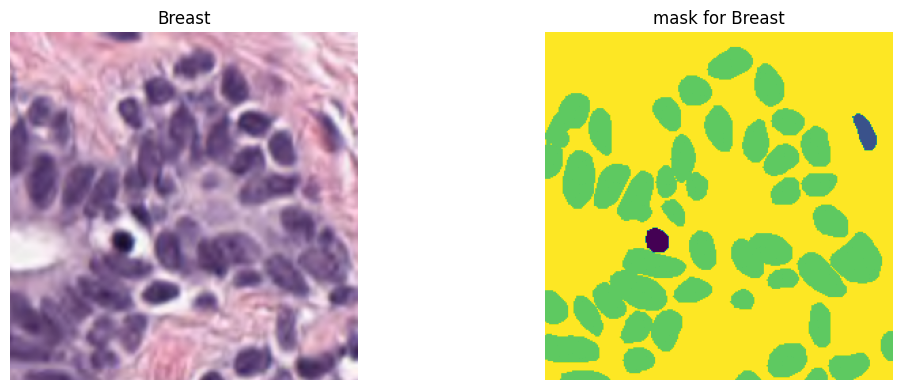

In [9]:
images=images.astype('int32')
visualize_image(images,masks,np.random.randint(0, images.shape[0]))

## Define the model

### Densenet model
Densely Connected Convolutional Networks - 2017
https://arxiv.org/pdf/1608.06993

![image.png](https://jesusutrera.com/articles/img/densenet01.jpg)

In [10]:
def mean_iou(y_true, y_pred, num_classes=6):
    """
    Computes the mean IoU for one-hot encoded masks.
    
    Parameters:
    - y_true: Ground truth one-hot encoded masks, shape (batch_size, height, width, num_classes)
    - y_pred: Predicted one-hot encoded masks, shape (batch_size, height, width, num_classes)
    - num_classes: Number of segmentation classes
    
    Returns:
    - mean IoU score across all classes
    """
    # Convert one-hot encoded predictions and labels to class indices
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    
    iou_scores = []
    
    for i in range(num_classes):
        # Create masks for the current class
        true_class = tf.equal(y_true, i)
        pred_class = tf.equal(y_pred, i)
        
        # Calculate intersection and union
        intersection = tf.reduce_sum(tf.cast(true_class & pred_class, tf.float32))
        union = tf.reduce_sum(tf.cast(true_class | pred_class, tf.float32))
        
        # Avoid division by zero; only add IoU if the union is greater than zero
        iou = tf.math.divide_no_nan(intersection, union)
        iou_scores.append(iou)
    
    # Compute mean IoU across all classes
    mean_iou = tf.reduce_mean(tf.stack(iou_scores))
    
    # Return the result of the MeanIoU calculation
    return mean_iou

In [11]:
# In this instance we will try to train an image segmentation model using U-Net as the model
def build_densenet(input_size=(256, 256, 3), num_classes=6):
    # Based on:
    # - https://jesusutrera.com/articles/article08.html

    # Input layer
    inputs = layers.Input(shape=input_size)

    # Use Keras' DenseNet121 as the backbone, without the top fully connected layers
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_size)

    # We will leverage the ImageNet trainned weights by freezing the layers of DenseNet, 
    # pre-trainned with ImageNet, for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    # The encoder part (using DenseNet as a feature extractor)
    x = base_model(inputs)

    # Decoder part: Upsampling and Convolution to get segmentation mask (256, 256)
    # Upsample from 8x8 -> 16x16
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    # Upsample from 16x16 -> 32x32
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    # Upsample from 32x32 -> 64x64
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    # Upsample from 64x64 -> 128x128
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    # Upsample from 128x128 -> 256x256
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

    # Output layer: final segmentation map with the number of classes (6)
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    # Define the model
    model = models.Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', mean_iou])

    return model

In [13]:
model = build_densenet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 512)      │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 6)    │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,324,006 (50.83 MB)

 Trainable params: 6,286,502 (23.98 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

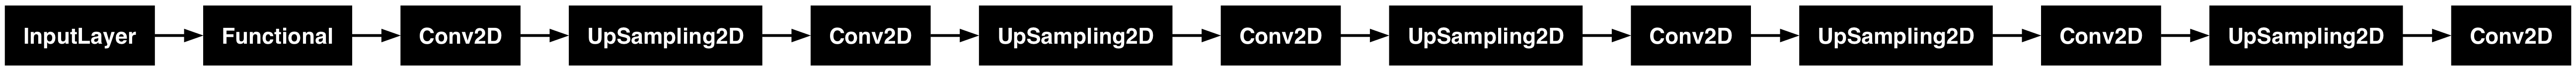

In [14]:
keras.utils.plot_model(model, rankdir="LR")
# keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Trainning the model

In [15]:
# Divide the dataset into trainning (70%), validation (10%) and tests (20%)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.66, random_state=42)

In [16]:
print(f"X trainning samples: {X_train.shape}")
print(f"X validation samples: {X_val.shape}")
print(f"X testing samples: {X_test.shape}")
print(f"y trainning samples: {y_train.shape}")
print(f"y validation samples: {y_val.shape}")
print(f"y testing samples: {y_test.shape}")

X trainning samples: (1859, 256, 256, 3)
X validation samples: (270, 256, 256, 3)
X testing samples: (527, 256, 256, 3)
y trainning samples: (1859, 256, 256, 6)
y validation samples: (270, 256, 256, 6)
y testing samples: (527, 256, 256, 6)


In [17]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # Monitor the validation set accuracy
    mode='max',                 # Consider higher validation accuracy as better
    patience=5,                 # Wait for a single epoch of no improvement before stopping
    restore_best_weights=True   # Restore weights from the best epoch with the highest validation accuracy
)

In [18]:
# Train the model
batch_size = 16
epochs = 50

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    callbacks=[early_stopping]
)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.0949 - loss: 504241913856.0000 - mean_iou: 0.0161 - val_accuracy: 0.0994 - val_loss: 28086282223616.0000 - val_mean_iou: 0.0165
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.1030 - loss: 366547004555264.0000 - mean_iou: 0.0172 - val_accuracy: 0.0994 - val_loss: 4665503251431424.0000 - val_mean_iou: 0.0165
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.1045 - loss: 17849372981067776.0000 - mean_iou: 0.0174 - val_accuracy: 0.0994 - val_loss: 91295602960236544.0000 - val_mean_iou: 0.0165
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.1049 - loss: 219266618855784448.0000 - mean_iou: 0.0175 - val_accuracy: 0.0994 - val_loss: 620547320286543872.0000 - val_mean_iou: 0.0165
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.1030 - loss: 1237134199689838592.0000 - mean_iou: 0.0172 - val_accuracy: 0.0994 - val_loss: 2747251847789019136.0000 - val_mean_io

In [19]:
# Evaluate the model
test_loss, test_acc, test_iou = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}, Test IoU: {test_iou}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.0914 - loss: 36624914186240.0000 - mean_iou: 0.0153
Test loss: 36250257981440.0, Test accuracy: 0.09695182740688324, Test IoU: 0.01640361174941063


In [20]:
# Finally, save the trainned model for latter use
model.save("my_densenet_model.keras")

## Result visualization

In [21]:
def visualize_single_prediction(model, image, mask):
    """
    Visualizes a single image with its predicted mask and true mask.
    
    Parameters:
    - model: Trained Keras model for segmentation.
    - image: Numpy array of the image to be segmented, shape (256, 256, 3).
    - mask: Numpy array of the ground truth mask, shape (256, 256, 6).
    """
    # Predict the mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Predict on a single image

    # Set up the figure
    plt.figure(figsize=(12, 4))

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Plot the predicted mask (argmax to get the class with highest probability)
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(pred_mask, axis=-1), cmap="viridis")
    plt.title("Predicted Mask")
    plt.axis("off")

    # Plot the true mask
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(mask, axis=-1), cmap="viridis")
    plt.title("True Mask")
    plt.axis("off")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


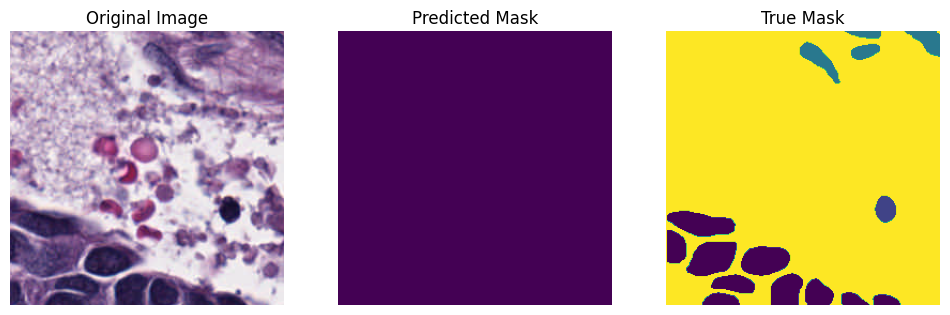

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


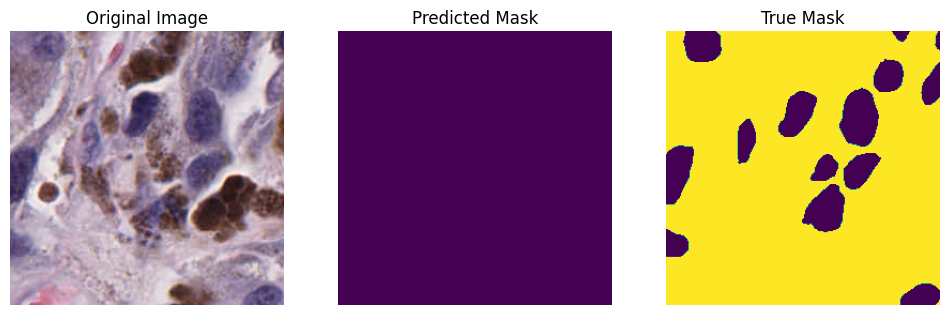

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


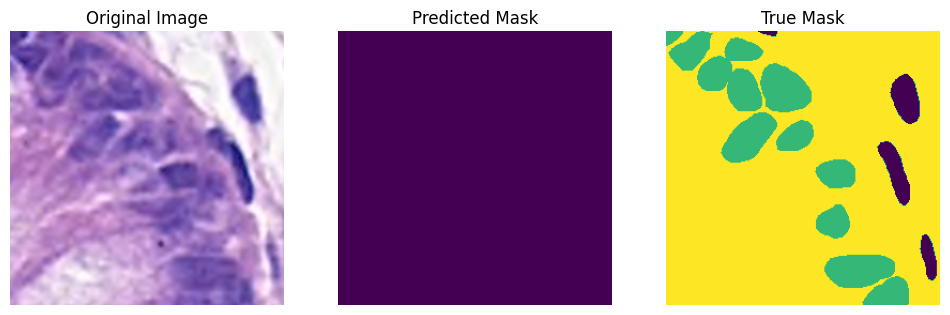

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


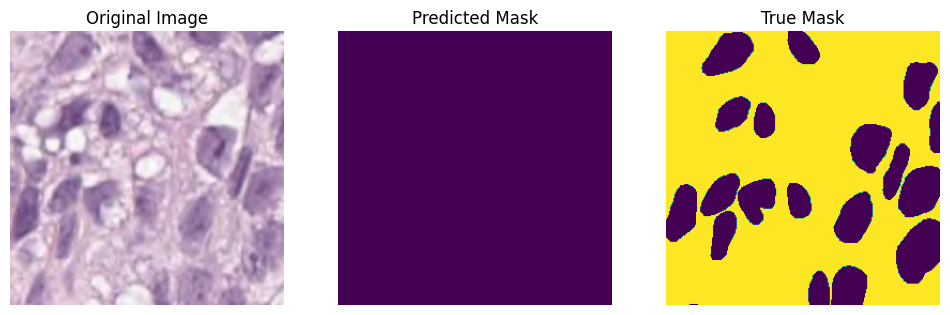

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


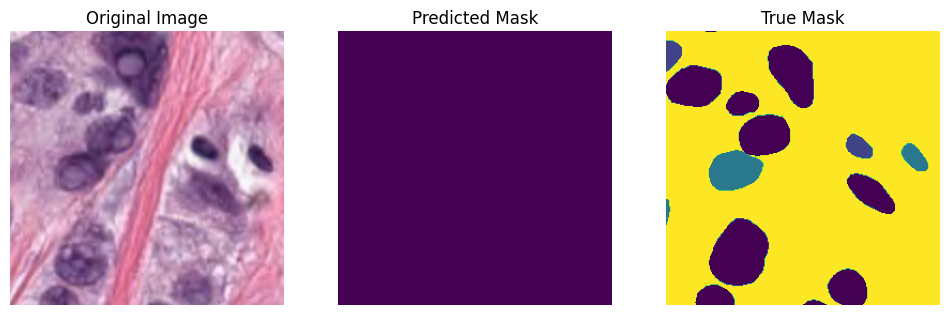

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


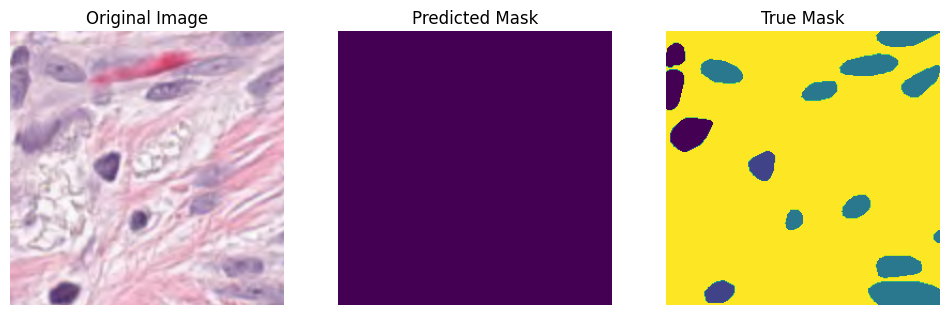

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


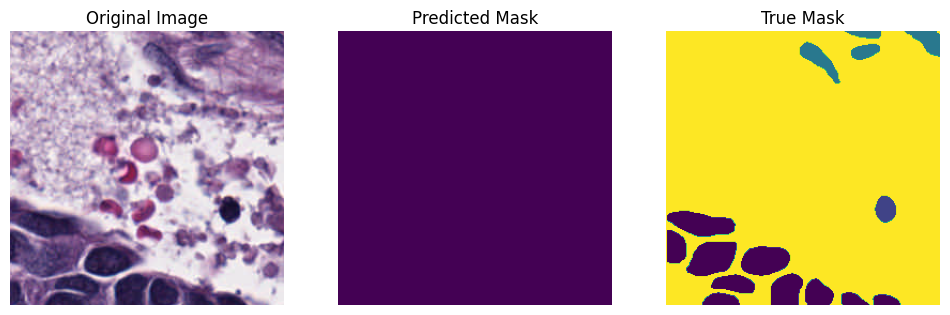

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


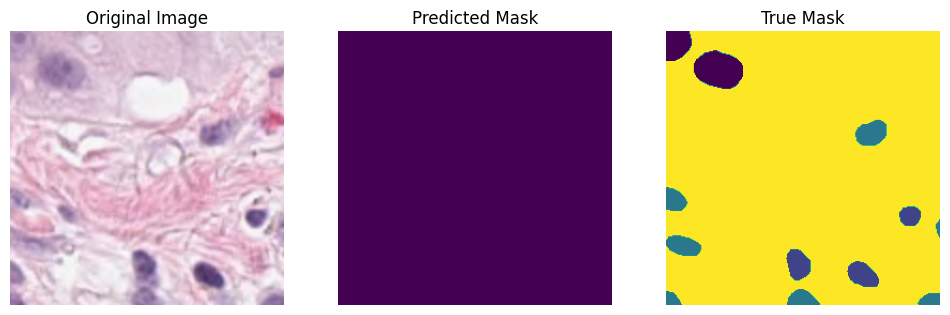

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


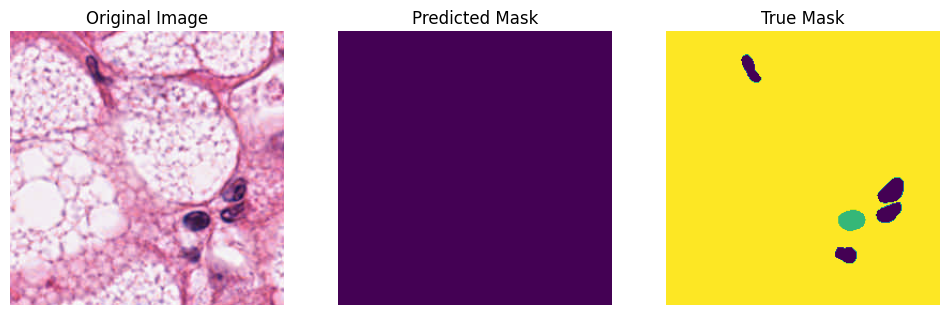

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


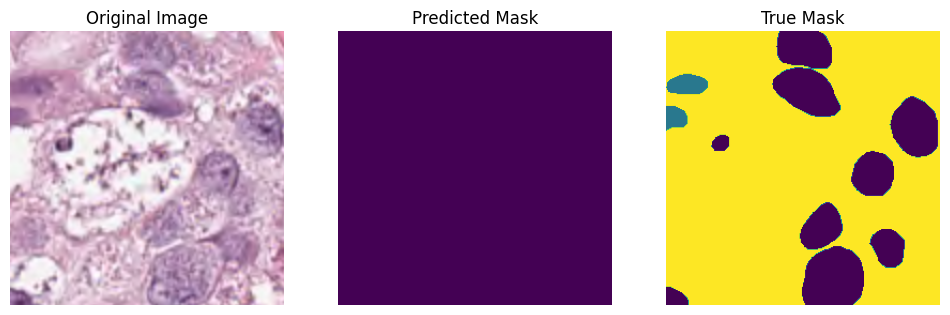

In [22]:
# Visualize 10 random samples from the test dataset
for _ in range(10):
    # Select a random index
    index = np.random.randint(0, X_test.shape[0])

    # Get the image and true mask
    image = X_test[index]
    true_mask = y_test[index]

    # Visualize the image, predicted mask, and true mask
    visualize_single_prediction(model, image, true_mask)